In [2]:
# import modules
import numpy as np
import pandas as pd
import re, os, glob
import matplotlib.pyplot as plt
from matplotlib import rcParams, cycler
import seaborn as sns
from scipy import interpolate

# map functions
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM

# ordinary least squares
from statsmodels.formula.api import ols

# scikit-learn machine learning
from sklearn import svm, metrics
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso, LinearRegression, SGDRegressor, RANSACRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import Normalizer, StandardScaler, normalize, scale
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel

# for graphing decision trees
import graphviz 
from sklearn.tree import export_graphviz

plt.style.use('seaborn-colorblind')

# special Jupyter Notebook command to prepare the notebook for matplotlib and other libraries
%matplotlib inline 

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set_style("darkgrid")
sns.set_context("notebook")

In [3]:
# read cleaned data file
earnings = pd.read_csv('earnings.csv', index_col=False)
earnings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152544 entries, 0 to 152543
Data columns (total 15 columns):
name           152544 non-null object
department     152544 non-null object
title          152544 non-null object
regular        152544 non-null float64
retro          152544 non-null float64
other          152544 non-null float64
overtime       152544 non-null float64
injured        152544 non-null float64
detail         152544 non-null float64
quinn          152544 non-null float64
total          152544 non-null float64
zip            152544 non-null object
year           152544 non-null int64
dept_clean     152544 non-null object
title_clean    152544 non-null object
dtypes: float64(8), int64(1), object(6)
memory usage: 17.5+ MB


In [33]:
# get top 10 titles by number of employees

titles_top10 = earnings\
                .groupby('title_clean')\
                .agg('size')\
                .sort_values(ascending=False)\
                .index[:10]

# get top 10 departments by number of employees

departments_top10 = earnings\
                .groupby('dept_clean')\
                .agg('size')\
                .sort_values(ascending=False)\
                .index[:10]
print(titles_top10)
print(departments_top10)

Index(['Teacher', 'Police Officer', 'Paraprofessional', 'Fire Fighter', 'Substitute Teacher', 'Lunch Hour Monitors', 'Part-Time Cafeteria Attendant', 'Cab Monitor', 'Police Detective', 'Police Sergeant'], dtype='object', name='title_clean')
Index(['Boston Public Schools', 'Boston Police Department', 'Boston Fire Department', 'Boston Cntr - Youth & Families', 'Boston Public Library', 'Public Works Department', 'Traffic Division', 'Parks Department', 'Inspectional Services Dept', 'Public Facilities Department'], dtype='object', name='dept_clean')


# Classification based on job titles and departments

- extract the 10 most common job titles and 10 largest departments for 2017
- run classifiers on the numeric earnings data

In [41]:
# top 10 titles and departments observations in 2017
top10 = earnings[earnings['title_clean'].isin(titles_top10) & (earnings.year == 2017)]
print('Number of observations by title:', top10.shape[0])

top10_d = earnings[earnings['dept_clean'].isin(departments_top10) & (earnings.year == 2017)]
print('Number of observations by department:', top10_d.shape[0])


Number of observations by title: 11430
Number of observations by department: 20563


### 1. Regression: Predict total earnings

This is a trivial exercise since "total" is the sum of all other numerical columns.

In [36]:
# data for linear regression:

# remove non-numeric columns as well as "total" and "quinn"
X_lm = top10.drop(['name', 'department', 'title', 'quinn', 'total', 'zip', 'year', 'title_clean', 'dept_clean'], axis=1)

y_lm = top10['total']

# split into training and test datasets
X_lm_train, X_lm_test, y_lm_train, y_lm_test = train_test_split(X_lm, y_lm, test_size=0.2, random_state=26)

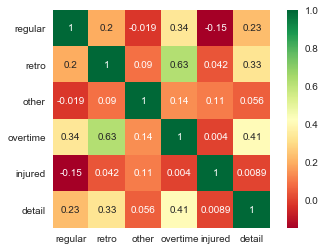

In [15]:
# heat map for identification of correlated data
sns.heatmap(X_lm.corr(), square=True, annot=True, cmap='RdYlGn')
plt.show()

The heat map above shows mostly red hues in the off-diagonal squares. This indicates low correlation between most of the earnings categories. Only "overtime" and "retro" show a green hue, suggesting that employees who collect overtime and more likely to collect retro earnings than those who don't.

In [37]:
# Linear Regression
lm = LinearRegression()

# Fit the regressor to the data
lm.fit(X_lm_train, y_lm_train)

print(pd.DataFrame(data={'features': X_lm.columns , 'estimatedCoefficients': list(lm.coef_)})\
      [['features', 'estimatedCoefficients']])

r_sq = lm.score(X_lm_test, y_lm_test)
print('The linear regression model explains {:.2f}% of the job title prediction variance.'.format(r_sq*100))

   features  estimatedCoefficients
0   regular               1.005860
1     retro               1.564228
2     other               1.051744
3  overtime               1.085879
4   injured               1.053268
5    detail               1.055482
The linear regression model explains 99.50% of the job title prediction variance.


Unsurprisingly, the linear regression model has an R-squared of almost 100%. This is an obvious result since the "total" is the numerical sum of the independent variables (Note that "quinn" earnings are removed from this dataset).

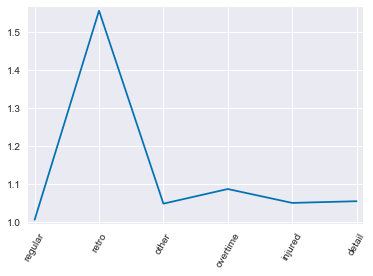

The linear regression model explains 99.50% of the job title prediction variance.


In [38]:
# Instantiate a lasso regressor: lasso
lasso = Lasso(alpha=0.4, normalize=True)

# Fit the regressor to the data
lasso.fit(X_lm_train, y_lm_train)

# Compute and print the coefficients
lasso_coef = lasso.coef_

# Plot the coefficients
plt.plot(range(len(X_lm.columns)), lasso_coef)
plt.xticks(range(len(X_lm.columns)), X_lm.columns.values, rotation=60)
plt.margins(0.02)
plt.show()

r_sq = lasso.score(X_lm_test, y_lm_test)
print('The linear regression model explains {:.2f}% of the job title prediction variance.'.format(r_sq*100))

"retro" is the most important coefficient for the prediction of total earnings.

### 2. Classification by job title

In [56]:
# data for classifiers (now including quinn):

# remove non-numeric columns as well as "total" and "quinn"
X = top10.drop(['name', 'department', 'title', 'quinn', 'total', 'zip', 'year', 'title_clean', 'dept_clean'], axis=1)

# factorize job titles
# y = pd.factorize(top10['title_clean'])[0]
y = top10['title_clean']

# split into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=26)
y_test.shape[0]

2286

In [58]:
# Instantiate a RidgeClassifier:
rclf = RidgeClassifier(alpha=0.01, normalize=True)

# Fit the regressor to the data
rclf.fit(X_train, y_train)

# Compute and print the coefficients
rclf_coef = rclf.coef_

r_sq = rclf.score(X_test, y_test)
print('The ridge classifier correctly identifies {:.2f}% of the job titles.'.format(r_sq*100))

The ridge classifier correctly identifies 58.18% of the job titles.


In [84]:
# support vector classifier

steps = [('scaler', StandardScaler()), ('clf', svm.SVC())]
pipeline = Pipeline(steps)
pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

# metrics:
print('Score:', pipeline.score(X_test, y_test))

pred = pipeline.predict(X)
# a2 = metrics.accuracy_score(y_test, pred)
# print('Accuracy:', a2)
cm = pd.DataFrame(metrics.confusion_matrix(y, pred)).set_index(np.sort(top10['title_clean'].unique()))
cm['count'] = cm.sum(axis=1)
cm['score'] = 0
for row in range(10):
    cm.iloc[row, 11] = round(cm.iloc[row, row] / cm.iloc[row, 10] * 100, 2)
print(cm)
cv_scores = cross_val_score(pipeline, X, y, cv=10)
print('mean cv score:', np.mean(cv_scores), '\n')

Score: 0.7817147856517935
                               0     1   2    3    4    5     6    7    8     9  count  score
Cab Monitor                    0     0   6  223   26    0     0    0   51     0    306   0.00
Fire Fighter                   0  1043   1    3    0    0    22   11    2    42   1124  92.79
Lunch Hour Monitors            0     0  11   31    8    0     0    0  309     1    360   3.06
Paraprofessional               0     1  28  982   58    0     0    0   81    65   1215  80.82
Part-Time Cafeteria Attendant  0     0  26  105  144    0     0    0   59     0    334  43.11
Police Detective               0     0   0    0    0  169   124    0    4     1    298  56.71
Police Officer                 0     7   3   89    0   27  1421    5   55     9   1616  87.93
Police Sergeant                0    52   0    0    0    4    32  194    1    16    299  64.88
Substitute Teacher             0     0  12   71   32    0     0    0  319     7    441  72.34
Teacher                        0  

After scaling the independent variables, the SVC classifier correctly predicts the job title approximately 77% of the time. The most accurate predictions are for fire fighters and police officers. The least accurate predictions are for cab monitors and lunch hour monitors. The latter two jobs have a low count and are not full time positions, therefore most of the features are empty, i.e. "0". 

In [85]:
# Knn
clf = KNeighborsClassifier(n_neighbors=7)
clf.fit(X_train, y_train)

# metrics:
print('Score:', clf.score(X_test, y_test))

pred = clf.predict(X_test)
a2 = metrics.accuracy_score(pred, y_test)
print('Accuracy:', a2)

cv_scores = cross_val_score(clf, X, y, cv=10)
print('mean cv score:', np.mean(cv_scores), '\n')

Score: 0.8083989501312336
Accuracy: 0.8083989501312336
mean cv score: 0.7743580508842226 



KNN performs slightly better than SVC at predicting the correct job title from the earnings categories.

### 2. Classification by department

In [91]:
# data for classifiers (now including quinn):

# remove non-numeric columns as well as "total" and "quinn"
X = top10_d.drop(['name', 'department', 'title', 'quinn', 'total', 'zip', 'year', 'title_clean', 'dept_clean'], axis=1)

# factorize job titles
# y = pd.factorize(top10['title_clean'])[0]
y = top10_d['dept_clean']

# split into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=26)
y_test.shape[0]

4113

In [92]:
# support vector classifier

steps = [('scaler', StandardScaler()), ('clf', svm.SVC())]
pipeline = Pipeline(steps)
pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

# metrics:
print('Score:', pipeline.score(X_test, y_test))

pred = pipeline.predict(X)
# a2 = metrics.accuracy_score(y_test, pred)
# print('Accuracy:', a2)
cm = pd.DataFrame(metrics.confusion_matrix(y, pred)).set_index(np.sort(top10_d['dept_clean'].unique()))
cm['count'] = cm.sum(axis=1)
cm['score'] = 0
for row in range(10):
    cm.iloc[row, 11] = round(cm.iloc[row, row] / cm.iloc[row, 10] * 100, 2)
print(cm)
cv_scores = cross_val_score(pipeline, X, y, cv=10)
print('mean cv score:', np.mean(cv_scores), '\n')

Score: 0.8329686360320934
                                0     1     2  3      4   5  6   7    8    9  count  score
Boston Cntr - Youth & Families  0     2     0  0    544   0  0   0    0    0    546   0.00
Boston Fire Department          0  1446    48  0    136   1  0   0   23   26   1680  86.07
Boston Police Department        0   113  2208  0    771   0  0   1   21   35   3149  70.12
Boston Public Library           0     2     7  0    487   0  0   0    0    0    496   0.00
Boston Public Schools           0    31    17  0  13019   0  0   0    0    0  13067  99.63
Inspectional Services Dept      0     6    61  0     75  28  0   0   14   47    231  12.12
Parks Department                0    12    21  0    204   0  0   0   80   31    348   0.00
Public Facilities Department    0    20    20  0    136   0  1  35    3    1    216  16.20
Public Works Department         0    11    46  0    101   0  0   0  229   67    454  50.44
Traffic Division                0     5    25  0     91   3  0  

# Cluster Analysis

In [12]:
# KMeans
kmeans = KMeans(n_clusters=10)
labels = kmeans.fit_predict(X)

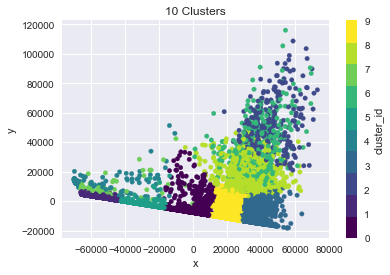

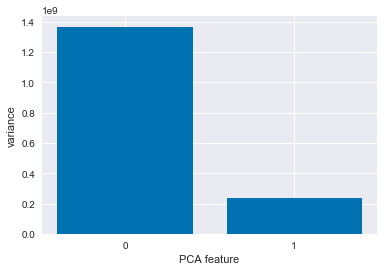

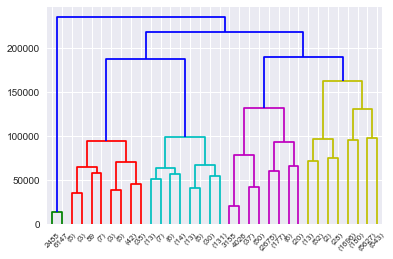

In [24]:
# reduce to two dimensions
pca = PCA(n_components=2)

components = pca.fit_transform(X)

y = top10['title_clean']

# add to data frame and plot
df_pca = pd.DataFrame({'title': y, 'cluster_id': labels, 'x': components[:,0], 'y': components[:,1]})\
            .plot.scatter('x', 'y', c='cluster_id', cmap=plt.cm.get_cmap('viridis', 10), sharex=False, title='10 Clusters')

plt.show()

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xticks(features)
plt.ylabel('variance')
plt.xlabel('PCA feature')
plt.show()

mergings = linkage(X, method='complete')
dendrogram(mergings, p=5, truncate_mode='level')
plt.show()

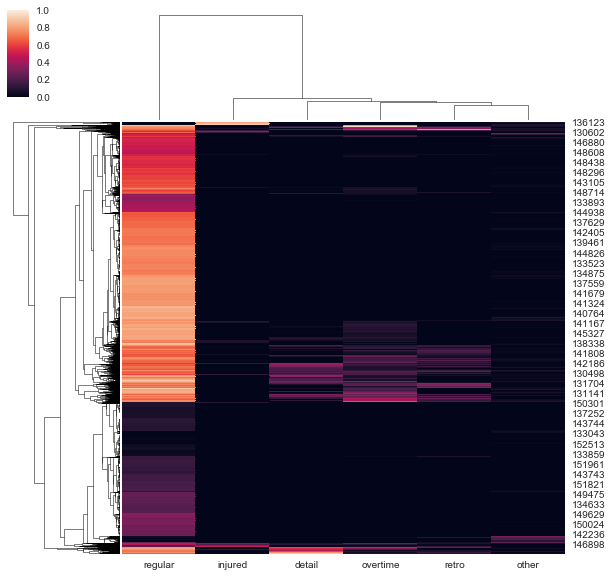

In [87]:
sns.clustermap(X, metric="euclidean", standard_scale=1)
plt.show()

Principal component analysis with cluster labels from a KMeans classfier show no clear boundaries between points. This suggests that job titles can not be predicted by the earnings data with sufficient accuracy. Likewise, it is difficult to identify an appropriate cutoff value for a dendrogram such that exactly 10 clusters (= job titles) are generated.

In [155]:
"""
compound annual growth rate

1. An arbitrary limit is set on "first" since low earnings are often not full time positions
2. An arbitrary cap on the growth rate result is needed for new hires whose first year earnings are not a full year
3. Negative growth is not allowed (part-time, retirement, resignation, termination, etc.)
"""

def cagr(first, last, periods=1): 
    if (first < 40000):
        return np.nan
    x = ((last/first) ** (1/periods) - 1 ) * 100
    if ((x > 22) & (periods == 1)) | (x < 0) : 
        return np.nan
    return x

In [156]:
# pivot earnings data to show annual earnings by name:
growth = pd.pivot_table(earnings, columns='year', index=['name'], values='regular')\
                    .reset_index()\
                    .apply(pd.to_numeric, errors='ignore')

# calculate CAGR for all available years:
years = (earnings.year.unique())
for previous, following in zip(years, years[1:]):
    growth['yoy' + str(following)] = growth.apply(lambda x: cagr(x[previous], x[following]), axis=1)

# drop names with no qualified CAGR entries:
c = growth.iloc[0:, -(len(years)-1):].columns
growth = growth.dropna(subset=c, how='all')

# merge with 'titles_clean' (both first and last) and 'dept_clean' (only the most recent):
titles = earnings.groupby('name')[['title_clean', 'dept_clean']]\
                 .agg({'title_clean':['first', 'last'], 'dept_clean':'last'})\
                 .reset_index()

# avoid multiindex issues:
titles.columns = ['_'.join(tup).rstrip('_') for tup in titles.columns.values]

# merge dataframes:
growth_title = growth.merge(titles, how='left', on='name')

# calculate compound annual growth rate for all available years:

growth_title['cagr_all'] = growth_title.apply(lambda y: cagr(y[2011], y[2011+len(years)-1], len(years)-1), axis=1)
growth_title.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 16221 entries, 0 to 16220
Data columns (total 18 columns):
name                 16221 non-null object
2011                 13163 non-null float64
2012                 13933 non-null float64
2013                 14721 non-null float64
2014                 15177 non-null float64
2015                 15051 non-null float64
2016                 14407 non-null float64
2017                 13698 non-null float64
yoy2012              8873 non-null float64
yoy2013              9584 non-null float64
yoy2014              10287 non-null float64
yoy2015              10778 non-null float64
yoy2016              7639 non-null float64
yoy2017              8301 non-null float64
title_clean_first    16221 non-null object
title_clean_last     16221 non-null object
dept_clean_last      16221 non-null object
cagr_all             8106 non-null float64
dtypes: float64(14), object(4)
memory usage: 2.4+ MB


There are over 1000 unique job titles and 50 departments in the earnings dataset. In order to prioritize the analysis, subsets will sometimes be generated to focus on the top 10:

                           yoy2012   yoy2013    yoy2014    yoy2015    yoy2016   yoy2017  mean_rows  cagr_all
title_clean_first                                                                                           
Teacher                   4.040561  5.984074   5.758944   9.373089   4.751721  4.580495   6.016875  3.745675
Police Sergeant           2.089566  2.721173   8.483153  11.112521   2.239219  1.325387   5.362431  4.006218
Police Officer            2.366742  2.442829  14.404099   7.821254   3.218319  6.649635   6.348318  5.256190
Police Detective          1.033808  1.326743   1.572922   2.518039  17.051179  5.904420   4.584125  4.970954
Parking Meter Supervisor  2.740584  4.790012   5.833529   6.576075   3.660477  4.416928   4.813606  3.254662
Paraprofessional          4.450372  8.881443   7.627653  10.595755   7.978553  5.845892   7.786584  5.262935
Nurse                     3.301549  5.458083   4.716457   8.769313   5.363786  5.843652   5.647477  3.451910
Librarian          

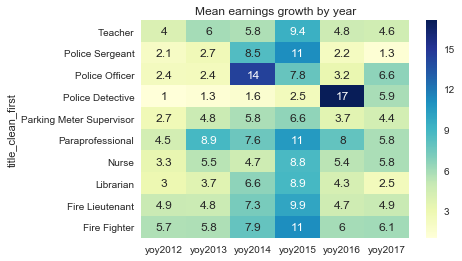

In [162]:
# get top 10 titles by number of employees

titles_top10 = growth_title[growth_title['title_clean_first'] == growth_title['title_clean_last']]\
                .groupby('title_clean_first')\
                .agg('size')\
                .sort_values(ascending=False)\
                .index[:10]

# keep only growth rate columns ('yoy...') and top 10 title rows

payraise = growth_title.iloc[:, len(years)+1:(len(years)*2)+1]
payraise = payraise[payraise['title_clean_first'].isin(titles_top10)]

# calculate means and mean of means

payraise = payraise.set_index('title_clean_first')
payraise['mean_rows'] = payraise.stack().groupby(level=0).mean()
payraise  = payraise.groupby(payraise.index).agg('mean')
payraise = payraise[::-1]

# append all years cagr:

cagr_all = growth_title[['title_clean_first', 'cagr_all']]
cagr_all = cagr_all.groupby('title_clean_first')[['title_clean_first', 'cagr_all']].agg('mean')
payraise = payraise.merge(cagr_all, how='left', left_index=True, right_index=True)
payraise.loc['mean_columns'] = payraise.mean()
print(payraise)
sns.heatmap(payraise.drop('mean_columns').drop(['mean_rows', 'cagr_all'], axis=1), annot=True, cmap="YlGnBu")
plt.title('Mean earnings growth by year')
plt.show()

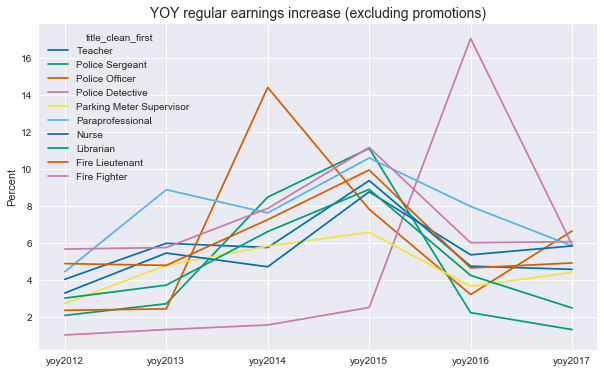

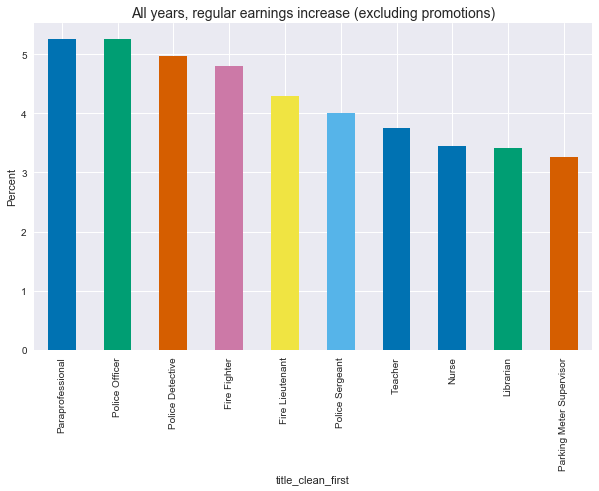

In [17]:
# pay raises by year

 
# plot
ax = payraise.drop('mean_columns').drop(columns=['mean_rows', 'cagr_all']).T.plot(figsize=(10,6), xticks=[0,1,2,3,4,5])
ax.set_ylabel('Percent')
ax.set_title('YOY regular earnings increase (excluding promotions)', fontsize=14)
plt.show()

# pay raises - all years
ax = payraise.drop('mean_columns').sort_values('cagr_all', ascending=False).iloc[:,-1].T.plot(kind='bar',figsize=(10,6), xticks=[0,1,2,3,4,5])
ax.set_ylabel('Percent')
ax.set_title('All years, regular earnings increase (excluding promotions)', fontsize=14)
plt.show()


The most interesting observation from these charts are the two spikes in regular earnings growth rates, 15% for police officers in 2014 and 17% for police detectives in 2016. While this may seem at first very generous, it was preceded by several years of virtually no regular earnings increases. In the end, the average growth rate is about 5% annually for both job titles, which is only slightly higher than most other job titles. More years of earnings data would be needed to 

The only job title with a higher average regular earnings growth rate is "Paraprofessional". Paraprofessional is typically not a steady, full time career. This can make the growth rate artificially high.  

In [18]:
# Extract growth columns
c = [k for k in growth_title.columns if 'yoy' in str(k)]
growth_pred = growth_title[c].fillna(0)

# do I need to convert year to number?

growth_pred.columns = list(range(len(years)-1))


X = growth_pred.drop(5, axis=1).stack().reset_index().drop('level_0', axis=1)
X = X.rename(columns={'level_1': 'year', 0: 'cagr'})
print(X.tail(20))
# y = pd.factorize(growth_title['title_clean_first'])
y = growth_title['yoy2017'].fillna(0)


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=26)

# logistic regression:
# rc = RidgeClassifier()
# rc.fit(X_train, y_train)
# cv_scores = cross_val_score(rc, X_train, y_train, cv=10, scoring='roc_auc')
# print('mean cv score:', np.mean(cv_scores), '\n')

# # hyper-parameter tuning
# param_grid = {'C': [0.001, 0.1, 1, 10, 100]}

# gs = GridSearchCV(lrc, param_grid, cv=10)
# gs.fit(X_train, y_train)
# print(gs.best_params_)
# print(gs.best_score_)
# cv_scores = cross_val_score(lrc, X, y, cv=10, scoring='roc_auc')
# print('mean cv score:', np.mean(cv_scores), '\n')

       year       cagr
81085     0   0.323188
81086     1   2.922107
81087     2   2.915162
81088     3   7.059178
81089     4   0.000000
81090     0   0.965963
81091     1   4.000173
81092     2   0.000000
81093     3   0.000000
81094     4   0.000000
81095     0   0.000000
81096     1   0.000000
81097     2   4.461912
81098     3   6.284562
81099     4   0.000000
81100     0   0.000000
81101     1   0.000000
81102     2   0.000000
81103     3  18.295745
81104     4   4.096592


In [ ]:
# keep only growth rate columns ('yoy...') and limit titles
titles_4plot = ['Police Officer', 'Police Detective', 'Police Sergeant']
payraise = growth_title.iloc[:, len(years)+1:(len(years)*2)+1]
payraise = payraise[payraise['title_clean_first'].isin(titles_4plot)].fillna(0)

#plot
sns.pairplot(payraise, hue='title_clean_first')


In [ ]:
# extract 10 largest departments
departments = earnings[earnings['year'] == 2017].groupby('dept_clean')['name'].agg(np.size).nlargest(10)
dept_list = departments.index
departments = earnings[(earnings['dept_clean'].isin(dept_list)) & (earnings['year'] == 2017)] \
                    .rename(index=str, columns={'dept_clean': 'Department'})  # for plot legend

In [ ]:
# extract 10 most common job titles
titles = earnings[earnings['year'] == 2017].groupby('title_clean')['name'].agg(np.size).nlargest(10)
titles_list = titles.index
titles = earnings[(earnings['title_clean'].isin(titles_list)) & (earnings['year'] == 2017)] \
                .rename(index=str, columns={'title_clean': 'Job Title'})  # for plot legend

In [ ]:
usecols = ['regular', 'retro', 'other', 'overtime', 'injured', 'detail']
g = sns.pairplot(departments, hue='Department', vars=usecols, plot_kws={"s": 20}, palette="bright")
g.fig.subplots_adjust(top=.93)
g.fig.suptitle('Pairplots of 2017 numerical columns\nTop 10 departments', fontsize=16)
plt.show()

In [ ]:
g = sns.pairplot(titles, hue='Job Title', vars=usecols, plot_kws={"s": 20}, palette="bright")
g.fig.subplots_adjust(top=.93)
g.fig.suptitle('Pairplots of 2017 numerical columns\nTop 10 job titles', fontsize=16)
plt.show()

The paired scatter plots above show the relationship between all of the numerical columns in the dataframe with exception of "Quinn" which is an education incentive specific to the police department, and "Total", which is the sum of the numerical columns. 

A few general observations follow:

- The charts are dominated by the highest paid employees: Police and fire fighters. 
- "Retro" payments are almost exclusive to the police department.
- "Overtime" is primarily for middle income employees. Salaried employees don't usually get overtime pay and lower income employees get overtime pay proportional to their income.
- "Injured" pay is mostly for police and fire fighters, and it appears to replace "regular" pay.
- "Detail" and "overtime" scatter plots have similar shapes and may possibly be alternative categories for similar compensation.

2017 number of employees: 4416


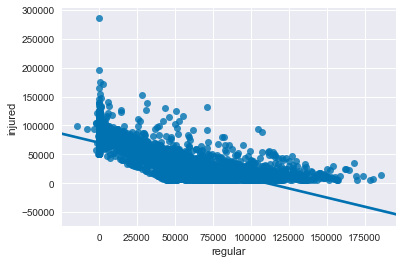

In [8]:
""" 
dataset focused on 'normal' income levels with both regular and injured earnings types
"""
injured = earnings[((earnings.injured + earnings.regular) > 50000)  & (earnings.injured > 5000)] # & (earnings.year == 2017)]
print('2017 number of employees:', injured.shape[0])
sns.regplot(x='regular', y='injured', data=injured)
plt.show()

In [10]:
m = ols('regular ~ injured',injured).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:                regular   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.596
Method:                 Least Squares   F-statistic:                     6525.
Date:                Sun, 29 Apr 2018   Prob (F-statistic):               0.00
Time:                        08:01:47   Log-Likelihood:                -50537.
No. Observations:                4416   AIC:                         1.011e+05
Df Residuals:                    4414   BIC:                         1.011e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   9.122e+04    493.676    184.787      0.0

(4416, 6)


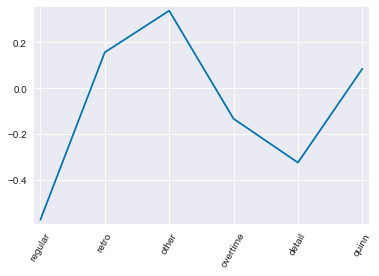

The linear regression model explains 63.41% of the injured earnings prediction variance.


In [154]:
# predict injured pay from other earnings categories
# remove non-numeric columns as well as "total" 
X = injured.drop(['name', 'department', 'title', 'injured', 'total', 'zip', 'year', 'title_clean', 'dept_clean'], axis=1)
print(X.shape)
# factorize job titles
y = injured['injured']

# split into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=26)


# Instantiate a lasso regressor: lasso
lasso = Lasso(alpha=1.0, normalize=True, random_state=26)

# Fit the regressor to the data
lasso.fit(X_train, y_train)

sgdr.fit(X_train, y_train)

# Compute and print the coefficients
lasso_coef = lasso.coef_

# Plot the coefficients
plt.plot(range(len(X.columns)), lasso_coef)
plt.xticks(range(len(X.columns)), X.columns.values, rotation=60)
plt.margins(0.02)
plt.show()

r_sq = lasso.score(X_test, y_test)
print('The linear regression model explains {:.2f}% of the injured earnings prediction variance.'.format(r_sq*100))


In [126]:
print(X_test.shape)
# lasso.feature_importances_  
model = SelectFromModel(lasso, prefit=True)
X_new = model.transform(X_test)
print(X_new.shape)
# importances = pd.DataFrame([X_test.columns, lasso.feature_importances_])\
#                 .T.rename(columns={0:'feature', 1:'importance'})\
#                 .sort_values(by='importance', ascending=False)
# print(importances)

(1325, 6)
(1325, 6)


In [ ]:
# Plot the feature importances of the lasso regressor
fig, ax = plt.subplots(facecolor='powderblue', figsize=(8,5))
importances.plot('feature', 'importance', kind='bar', color="b", yerr='std', align="center", ax=ax)
plt.title('Feature importances', fontsize=14)
plt.ylabel('importance')
ax.set_xticklabels(importances['feature'], rotation=0, fontsize=14)
plt.show()

In [ ]:
# logistic regression:
lrc = LogisticRegression()
lrc.fit(X_train, y_train)
cv_scores = cross_val_score(lrc, X_train, y_train, cv=10, scoring='roc_auc')
print('mean cv score:', np.mean(cv_scores), '\n')

# hyper-parameter tuning
param_grid = {'C': [0.001, 0.1, 1, 10, 100]}

gs = GridSearchCV(lrc, param_grid, cv=10)
gs.fit(X_train, y_train)
print(gs.best_params_)
print(gs.best_score_)
cv_scores = cross_val_score(lrc, X, y, cv=10, scoring='roc_auc')
print('mean cv score:', np.mean(cv_scores), '\n')


In [ ]:
# train a decision tree classifier:
dtc = DecisionTreeClassifier(max_depth=2, min_samples_split=100)
dtc.fit(X_train, y_train)

# metrics:
print('Score:', dtc.score(X_test, y_test))
cm = metrics.confusion_matrix(y, dtc.predict(X))
print('Confusion matrix:', '\n', cm)
accuracy = (cm[0][0] + cm[1][1])/pol_ff.shape[0]
a2 = metrics.accuracy_score(dtc.predict(X_test), y_test)
print('Accuracy:', accuracy, '\n', a2)
cv_scores = cross_val_score(dtc, X, y, cv=10)
print('mean cv score:', np.mean(cv_scores), '\n')


In [ ]:
dot_data = export_graphviz(dtc, out_file=None) 
graph = graphviz.Source(dot_data) 
graph


In [ ]:
# train a random forest classifier:
rfc = RandomForestClassifier(n_estimators=100, max_depth=8, min_samples_split=20)
rfc.fit(X_train, y_train)

# metrics:
print('Score:', rfc.score(X_test, y_test))
cm = metrics.confusion_matrix(y, rfc.predict(X))
print('Confusion matrix:', '\n', cm)
accuracy = (cm[0][0] + cm[1][1])/pol_ff.shape[0]
a2 = metrics.accuracy_score(rfc.predict(X_test), y_test)
print('Accuracy:', accuracy, '\n', a2)
cv_scores = cross_val_score(rfc, X, y, cv=10)
print('mean cv score:', np.mean(cv_scores), '\n')

# generate feature importances and standard deviations dataframe
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)
importances = pd.DataFrame([X_test.columns, rfc.feature_importances_, std])\
                .T.rename(columns={0:'feature', 1:'importance', 2:'std'})\
                .sort_values(by='importance', ascending=False)
print(importances)

In [ ]:
# Plot the feature importances of the forest
fig, ax = plt.subplots(facecolor='powderblue', figsize=(8,5))
importances.plot('feature', 'importance', kind='bar', color="b", yerr='std', align="center", ax=ax)
plt.title('Feature importances', fontsize=14)
plt.ylabel('importance')
ax.set_xticklabels(importances['feature'], rotation=0, fontsize=14)
plt.show()

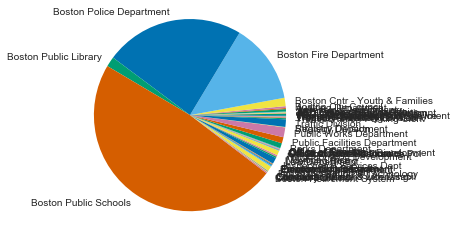

In [84]:
by_dept = earnings.groupby('dept_clean')['total'].agg(np.sum)
plt.pie(by_dept, labels=by_dept.index)
plt.axis('equal')
plt.show()

Almost half of the total payroll goes towards the school department and almost one third towards the police and fire departments. The remaining payroll is spread among 49 smaller departments.

In [ ]:
growth = pd.pivot_table(earnings, columns='year', index=['name', 'title_clean', 'dept_clean'], values='total')
print('Unique employees, 2011-2017:', growth.shape[0])
growth = growth.dropna()
growth['cagr'] = (growth.iloc[:,-1] / growth.iloc[:,-5]) ** (1/(len(growth.columns)-1)) - 1
growth = growth[growth['cagr'] > 0].reset_index() # filter retirees etc.
print('Continuously employed, 2011-2017', growth.shape[0])
growth = growth.groupby('title_clean')['name','cagr'].agg({'name':np.size, 'cagr':np.mean})
growth = growth[growth['name'] > 50]
growth

In [ ]:
# total payroll by year
total_payroll = earnings.groupby(earnings['year'])[['regular', 'total', 'name']]\
                        .agg({'regular': np.sum, 'total': np.sum, 'name': 'count'})\
                        .reset_index()\
                        .set_index('year')
total_payroll['epc'] = total_payroll['total'] / total_payroll['name'] # average total earnings per capita
total_payroll['rpc'] = total_payroll['regular'] / total_payroll['name'] # average regular earnings per capita
total_payroll = total_payroll.reset_index()

""" 
Average wage index (AWI) for the United States
Source: https://www.ssa.gov/oact/cola/awidevelop.html
"""
total_payroll['awi'] = pd.Series([42979.61, 44321.67, 44888.16, 46481.52, 48098.63, 48642.15]) # AWI, years 2011-2016

"""
City of Boston population estimates
https://www.census.gov/quickfacts/fact/table/bostoncitymassachusetts/PST045216
2017 data is extrapolated from 2011-2016 data
"""

year_actual, pop_actual = np.array([2011, 2012, 2013, 2014, 2015, 2016]), \
                        np.array([630195, 641911, 651090, 659180, 665984, 673184])
f = interpolate.interp1d(year_actual, pop_actual, fill_value='extrapolate')
population = np.append(pop_actual, f(2017))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))

x = total_payroll['year']

# Total payroll by year
ax1.bar(x, total_payroll['total']/1000000)
ax1.set_xlabel('year')
ax1.set_ylabel('annual payroll expenditure (millions $)')
ax1.set_title('Total payroll by year')

# City population
ax2.bar(x, population/1000)
ax2.set_xlabel('year')
ax2.set_ylabel('Number of residents (thousands)')
ax2.set_title('City population (2017 estimated)')

# Employees per year
ax3.bar(x, total_payroll['name'])
ax3.set_xlabel('year')
ax3.set_ylabel('Number of employees')
ax3.set_title('Employees per year')

# Average earnings per employee
ax4.bar(x, total_payroll['epc'])
ax4.plot(x, total_payroll['rpc'], alpha=1, color='r', linewidth=4)
ax4.plot(x, total_payroll['awi'], color='y', linewidth=4)
ax4.set_xlabel('year')
ax4.set_ylabel('average earnings ($)')
ax4.set_title('Average earnings per employee')
ax4.legend(['regular earnings', 'SSA average wage index', 'total earnings'])
ax4.set_ylim(0, 100000)

plt.tight_layout()
plt.show()

The plots above show that the rate of payroll growth is slowing in the past few years. The number of employees has not grown since 2013 despite a growing population and the average earnings per employee are nearly stagnant since 2015.

In [ ]:
teachers = earnings[(earnings['year'] == 2017) & (earnings['title_clean'] == 'Teacher')][['regular', 'department']]
teachers.plot(kind='hist', bins=30, title='Histogram of Teacher\'s regular earnings')
plt.xlabel('regular earnings')
plt.show()

Three modes are visible in the histogram plot. The first at around \$20,000 could be due to part time work, new hires, retirees, etc. The third at around \$100,000 is what is generally considered a teacher's salary in Boston. The second between \$60,000 and \$80,000 is worth looking into. The chart below suggests that the title "Teacher" may have been inappropriately given to 

In [ ]:
# separate out the employees from the second mode from $60-85K
teachers70 = earnings[(earnings['year'] == 2017) \
                      & (earnings['title_clean'] == 'Teacher') \
                      & (earnings['regular'] > 60000) \
                      & (earnings['regular'] < 85000)] \
                      .groupby('department')\
                     [['regular', 'department']]\
                      .agg([np.median, np.size])\
                    .reset_index()
teachers70.columns = ['department', 'median', 'employees']
teachers70 = teachers70.sort_values(by='employees', ascending=False)[:20]
    
# for comparison: departments by size:
bps_depts = earnings[(earnings['year'] == 2017) \
                      & (earnings['title_clean'] == 'Teacher')] \
                     .groupby('department')\
                     ['name']\
                     .agg(np.size)\
            .reset_index()
            
bps_depts.columns = ['department', 'total_employees']

teachers_merged = pd.merge(teachers70, bps_depts, how='left', on='department')
                      
print(teachers_merged)

In [ ]:
# Median earnings by department for 2017. Small departments are excluded for better statistics.

large_depts = pd.pivot_table(earnings[earnings.year==2017], values='total', aggfunc=[np.size, np.median], index='dept_clean')
large_depts = large_depts[large_depts[('size', 'total')] > 200] \
              .sort_values([('median', 'total')], ascending=False)[:15]

# for later use
large_depts_list = large_depts.index 

large_depts.columns = large_depts.columns.droplevel(1)
large_depts = large_depts['median']

fig = plt.figure(figsize=(10, 8))                 
large_depts.plot.barh().invert_yaxis()

_ = plt.title('Median Earnings of Boston\'s Largest Departments', fontsize=15)
_ = plt.ylabel('Department')
_ = plt.xlabel('Median earnings')
_ = plt.rc('ytick', labelsize=12)
_ = plt.rc('axes', labelsize=12)

plt.show()

In [ ]:
# plot earnings growth by department
ld = pd.pivot_table(earnings, index='dept_clean', columns='year', values=['total'], aggfunc=np.median)
ld.columns = ld.columns.droplevel()
ld = ld.loc[large_depts_list].T # filter based on list above

fig, ax = plt.subplots(figsize=(8,8))
ld.plot(ax=ax)
ax.legend(bbox_to_anchor=(1.1, 1.05))
ax.set_title('median earnings growth by department')
ax.set_ylabel('US-$')
ax.set_xlabel('year')
# ax.set_yscale('log')

# cmap = plt.cm.hot
# rcParams['axes.prop_cycle'] = cycler(color=cmap(np.linspace(0, 1, len(ld.columns))))

plt.show()

In [ ]:
# fire fighters vs. police officers

ff = earnings[(earnings['title_clean'] == 'Police Officer')\
                             | (earnings['title_clean'] == 'Fire Fighter')]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.set_title('Median total earnings of police officers and fire fighters')
sns.violinplot(x='year', y='total', hue='title_clean', data=ff, split=True, ax=ax1,
              inner='quartile', palette='RdBu_r')
ax2.set_title('Median regular earnings of police officers and fire fighters')
sns.violinplot(x='year', y='total', hue='title_clean', data=ff, split=True, ax=ax2,
              inner='quartile', palette='RdBu_r')
plt.show()

In [ ]:
# fire fighters vs. police officers: Overtime

ff = earnings[(earnings['title_clean'] == 'Police Officer')\
                             | (earnings['title_clean'] == 'Fire Fighter')]

fig, ax= plt.subplots(figsize=(8, 6))
ax.set_title('Median overtime earnings of police officers and fire fighters')
sns.violinplot(x='year', y='overtime', hue='title_clean', data=ff, split=True, ax=ax,
              inner='quartile', palette='RdBu_r')
plt.show()

In [ ]:
# What???

retro = earnings[(earnings['title_clean'] == 'Police Officer')\
                             | (earnings['title_clean'] == 'Fire Fighter')]

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Median retro earnings of police officers and fire fighters')
sns.violinplot(x='year', y='retro', hue='title_clean', data=ff, split=True, ax=ax,
              inner='quartile', palette='RdBu_r')
plt.show()

In [ ]:
# retro earnings by year
retro_by_year = pd.pivot_table(earnings[earnings.retro != 0], columns='year', values='retro', index='dept_clean', aggfunc=[np.size, np.sum]).agg(np.sum)
print(retro_by_year)

In [ ]:
# by dept
retro_by_dept = pd.pivot_table(earnings[(earnings.year == 2014)], values='retro', index='dept_clean', aggfunc=np.sum).sort_values(by='retro', ascending=False)
print(retro_by_dept[:10])

In [ ]:
# by title
retro_by_title = earnings[(earnings.year == 2014) \
                          & (earnings.dept_clean.isin(['Boston Police Department', \
                                                        'Boston Fire Department']))]\
                        .groupby('title_clean')\
                        ['retro']\
                        .agg(np.sum)\
                        .sort_values(ascending=False)
print(retro_by_title[:10])


In [ ]:
# by name 2016
retro_by_name = earnings.loc[(earnings.year == 2016) & (earnings.title == 'Police Detective')]\
                    [['name', 'regular', 'retro']]\
                    .sort_values(by='retro', ascending=False)
print(retro_by_name[:20])

In [ ]:
greg = earnings.loc[earnings.name.str.startswith('Therriault')]
greg

In [ ]:
"""
1. Obtain latitude and longitude data for US zip codes from
https://www.census.gov/geo/maps-data/data/gazetteer2017.html

2. Count number of employees by zip code

3. Perform inner merge to get complete sets 

4. Filter Boston zip codes from suburban zip codes.
"""
zll = pd.read_csv('2017_Gaz_zcta_national.txt', sep='\t', encoding = "ISO-8859-1", usecols=[0, 5, 6], names=['zip', 'lat', 'long'], header=0, dtype={'zip': object})

zip_count = earnings[earnings.year == 2017].groupby('zip')['name'].agg(np.size).reset_index().rename(columns={'name': 'employees'})

zip_df = pd.merge(zip_count, zll, on='zip', how='inner')

# Read in Boston zipcode list
boston = pd.read_csv('boston-zipcodes.csv', names=['zip'], header=None, dtype={'zip': object})

# US population by zipcode (2010 Census)
population = pd.read_csv('2010+Census+Population+By+Zipcode+(ZCTA).csv', encoding = "ISO-8859-1", usecols=[0, 1], names=['zip', 'pop'], header=0, dtype={'zip': object})
population = population.groupby('zip')['pop'].agg(np.sum).reset_index()

# generate various zip code maps
boston = pd.merge(zip_df, boston, on='zip', how='inner')
suburbs = zip_df[~zip_df['zip'].isin(boston.zip)]

# by title
teachers = earnings[(earnings['year'] == 2017) & (earnings['title_clean'] == 'Teacher')].groupby('zip')['name'].agg(np.size).reset_index().rename(columns={'name': 'teachers'})
policemen = earnings[(earnings['year'] == 2017) & (earnings['title_clean'] == 'Police Officer')].groupby('zip')['name'].agg(np.size).reset_index().rename(columns={'name': 'police_officers'})
firemen = earnings[(earnings['year'] == 2017) & (earnings['title_clean'] == 'Fire Fighter')].groupby('zip')['name'].agg(np.size).reset_index().rename(columns={'name': 'fire_fighters'})
titles = teachers.merge(policemen, on='zip', how='outer')\
                .merge(firemen, on='zip', how='outer')\
                .merge(zll, on='zip', how='left')\
                .merge(population, on='zip', how='left')\
                .fillna(0)
titles = titles[titles['pop'] >= 1] # avoid div by zero error (and nonsense data)
titles['teachers_pc'] = titles['teachers'] / titles['pop'] * 100
                
# by income level 
rich = earnings[(earnings['year'] == 2017) & (earnings['total'] >= 81500)].groupby('zip')['name'].agg(np.size).reset_index().rename(columns={'name': 'employees'})
poor = earnings[(earnings['year'] == 2017) & (earnings['total'] < 81500) & (earnings['total'] >= 19917)].groupby('zip')['name'].agg(np.size).reset_index().rename(columns={'name': 'employees'})
rich = rich.merge(zll, on='zip', how='left').merge(population, on='zip', how='left')
poor = poor.merge(zll, on='zip', how='left').merge(population, on='zip', how='left')
rich = rich[rich['pop'] >= 1] # avoid div by zero error (and nonsense data)
poor = poor[poor['pop'] >= 1] # avoid div by zero error (and nonsense data)
rich['emp'] = rich['employees'] / rich['pop'] * 100
poor['emp'] = poor['employees'] / poor['pop'] * 100

# normalize "rich" employee count to match "poor":
print(rich.employees.sum(), poor.employees.sum())
# titles[titles['teachers_pc'] >1]

rich.head()

In [ ]:
# map image from open street maps
osm_tiles = OSM()

fig = plt.figure(figsize=(16, 16))
ax = plt.axes(projection=osm_tiles.crs)

# define map range
img_extent = (-71.8, -70.5, 42.85, 41.8)
ax.set_extent(img_extent, ccrs.PlateCarree())

# add map image, state lines
ax.add_image(osm_tiles, 9)
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor='none')
ax.add_feature(states_provinces, edgecolor='gray')

# suburban zip codes with at least 10 employees
suburbs_min10 = suburbs[suburbs['employees'] > 9]
suburbs_min10.plot('long','lat', kind='scatter', marker='.', s=suburbs_min10['employees'].values * 10, c='employees', cmap=plt.cm.inferno, ax=ax, transform=ccrs.PlateCarree())

ax.set_title('In which suburbs do Boston city employees live?', fontsize=15)
plt.savefig('suburbs.png')
plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, subplot_kw={'projection': osm_tiles.crs}, figsize=(16, 8))

# define map range
img_extent = (-71.3, -70.9, 42.45, 42.2)
ax1.set_extent(img_extent, ccrs.PlateCarree())
ax2.set_extent(img_extent, ccrs.PlateCarree())

# # add map image, state lines
ax1.add_image(osm_tiles, 10)
ax2.add_image(osm_tiles, 10)

poor.plot('long','lat', kind='scatter', marker='.', s=poor['emp'].values*1000, c='emp', cmap=plt.cm.inferno, ax=ax1, transform=ccrs.PlateCarree())
rich.plot('long','lat', kind='scatter', marker='.', s=rich['emp'].values*1000, c='emp', cmap=plt.cm.inferno, ax=ax2, transform=ccrs.PlateCarree())

ax1.set_title('Lower income employees', fontsize=12)
ax2.set_title('Higher income employees', fontsize=12)
plt.suptitle('Wealth segregation (equal populations)', fontsize=18)
plt.show()


In [ ]:
fig = plt.figure(figsize=(16, 16))
ax = plt.axes(projection=osm_tiles.crs)

# define map range
img_extent = (-71.8, -70.5, 42.85, 41.8)
ax.set_extent(img_extent, ccrs.PlateCarree())

# add map image, state lines
ax.add_image(osm_tiles, 9)
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor='none')
ax.add_feature(states_provinces, edgecolor='gray')

titles.plot('long','lat', kind='scatter', marker='.', s=titles['teachers_pc'].values * 1000, c='teachers_pc', cmap=plt.cm.inferno, ax=ax, transform=ccrs.PlateCarree())

ax.set_title('Where do Boston\'s public school teachers live?', fontsize=15)

plt.show()

In [ ]:
fig = plt.figure(figsize=(16, 16))
ax = plt.axes(projection=osm_tiles.crs)

# define map range (city of Boston)
img_extent = (-71.19, -70.985, 42.395, 42.23)
ax.set_extent(img_extent, ccrs.PlateCarree())

# add map image
ax.add_image(osm_tiles, 12)

# boston data
boston.plot('long','lat', kind='scatter', marker='.', s=boston['employees'].values*5, c='employees', cmap=plt.cm.viridis, ax=ax, transform=ccrs.PlateCarree())

ax.set_title('In which Boston neighborhoods do city employees live?', fontsize=16)

plt.show()

In [ ]:
"""
Adjusted Gross Income (AGI) by zip code

Available for years 1998 through 2015
from:
https://www.irs.gov/statistics/soi-tax-stats-individual-income-tax-statistics-2015-zip-code-data-soi

data:
https://www.irs.gov/pub/irs-soi/15zpallagi.csv
data documentation:
https://www.irs.gov/pub/irs-soi/15zpdoc.doc

"""
agi = pd.read_csv('15zpallagi.csv', encoding = "ISO-8859-1", usecols=['STATE', 'zipcode', 'agi_stub', 'N1', 'NUMDEP', 'A00100', 'A00200', 'A02650'], dtype={'zipcode': object})
print(agi.head())
agi['sum'] = agi['N1'] *  agi['A00100']
agi = agi.groupby('zipcode').agg(np.sum).reset_index()

agi['agi'] = agi['sum'] / agi['N1']

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
zipcode = earnings.groupby('zip')['total'].agg([np.size, np.median]).sort_values(by='size', ascending=False).reset_index()[:100]
zip_agi = pd.merge(zipcode, agi, left_on='zip', right_on='zipcode', how='left')
ax.scatter(zip_agi['agi'], zip_agi['median'])
ax.set_xlim(0, 1000000)
ax.set_xlabel('adjusted gross income ($, by zipcode)')
ax.set_ylabel('median income ($, by zipcode)')
ax.set_title('income by agi of zipcode')
# plt.xticks(rotation='vertical')
# ax.locator_params(nbins=25, axis='x')
plt.show()

## Residency Requirement
Boston city employees are required to live within city limits. The law is not strictly enforced and is confounded by state, federal and union regulations. 

https://www.boston.gov/departments/human-resources/residency-requirements-city-workers

https://www.bostonglobe.com/metro/2016/01/13/mayor-walsh-seeks-strengthen-boston-residency-requirement-with-caveat/ZyG8xmkOsu0dMHgITSUOKN/story.html

What does the distribution look like in 2017?

In [ ]:
# Read in Boston zipcode list
boston_zips = pd.read_csv('boston-zipcodes.csv', names=['bzips'], header=None)
boston_zips = boston_zips.astype(str).apply(lambda x: '0' + x) # treat zipcodes as strings and add leading "0"

# define resident and non-resident employees
inzips = earnings.loc[(earnings.zip.isin(boston_zips.bzips) & (earnings.year == 2017))]
outzips = earnings.loc[(~earnings.zip.isin(boston_zips.bzips) & (earnings.year == 2017))]
residents = inzips.shape[0] /(inzips.shape[0] + outzips.shape[0]) * 100

# income distribution
in_earnings = inzips['total'].agg(np.median)
print(in_earnings)
out_earnings = outzips['total'].agg(np.median)
zip_df = pd.DataFrame({'median earnings ($)': [in_earnings, out_earnings]}, index=['Residents', 'Non-residents'])
 
# plot
ax = zip_df.plot.bar(title='%s %% of city employees live in Boston (2017)'%(int(residents)), rot=0)
ax.set_ylabel("median earnings ($)")
plt.show()